In [58]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [4]:
models_path = "models/"
user_cascades_path = "../data/weibo_preprocessed/users_cascades.pkl"
infos_cascades_path = "../data/weibo_preprocessed/infos_cascades.pkl"
features_influencers_path = "../data/weibo_features/features_influencers_all_200_noCas.pkl"
features_targets_path = "../data/weibo_features/features_targets_all_200_noCas.pkl"
edges_file = '../data/weibo/weibodata/graph_170w_1month.txt'

In [5]:
u_to_userids = pd.read_csv("../data/weibo/weibodata/diffusion/uidlist.txt",header=None)
u_to_userids.columns = ['userid']
u_to_userids.index.name = 'uid'
infos_cascades = pd.read_pickle(infos_cascades_path)

infos_cascades_sample = infos_cascades.sample(n = 10000)
del(infos_cascades)

In [6]:
features_influencers = pd.read_pickle(features_influencers_path)
features_targets = pd.read_pickle(features_targets_path)
features_influencers = features_influencers.merge(u_to_userids.reset_index(), left_on=features_influencers.index, right_on = 'userid')
features_targets = features_targets.merge(u_to_userids.reset_index(), left_on=features_targets.index, right_on = 'userid')

In [9]:
d_fiu = defaultdict(lambda : False)
d_ftu = defaultdict(lambda : False)
for u in features_influencers.uid : d_fiu[u] = True
for v in features_targets.uid : d_ftu[v] = True

d_cascades = defaultdict(lambda : [])
for index, cascade in infos_cascades_sample.iterrows() : 
    u = cascade['User1']
    vs = cascade['users2']
    if d_fiu[u] : 
        for v in vs : 
            if d_ftu[v] : 
                d_cascades[u].append(v)

In [18]:
model_df = torch.load(models_path + "df_all_200_noCas.pt")
model_2s = torch.load(models_path + "2s_all_200_noCas.pt")

In [37]:
def feature(u,v) : 
    """
    u in d_cascades.keys() = inter(fiu, infos_cascades_sample)
    v in ftu
    """
    fu = features_influencers[features_influencers['uid'] == u].drop(columns = ['uid', 'userid'])
    fv = features_targets[features_targets['uid'] == v].drop(columns = ['uid', 'userid'])

    edge = 1 if v in d_edges[u] else 0 
    
    return torch.tensor(np.concatenate([fu, fv, edge], axis = None), dtype=torch.float).to('cuda')



In [86]:
mean = 0
for u in d_cascades : 
    mean += len(d_cascades[u])
mean / len(d_cascades.keys())

15.221218961625283

In [47]:
d_DP_df = {u:[] for u in d_cascades.keys()}
d_DP_2s = {u:[] for u in d_cascades.keys()}

for u in d_cascades : 
    for v in d_cascades[u] : 
        d_DP_df[u].append(model_df(feature(u, v)).item())
        d_DP_2s[u].append(model_2s(feature(u, v)).item())


In [87]:
random_vs = features_targets.sample(n = 15).uid
d_DP_df_random = {u:[] for u in d_cascades.keys()}
d_DP_2s_random = {u:[] for u in d_cascades.keys()}

for u in d_cascades : 
    for v in random_vs : 
        d_DP_df_random[u].append(model_df(feature(u, v)).item())
        d_DP_2s_random[u].append(model_2s(feature(u, v)).item())


In [94]:
d_mean = {u:[] for u in d_cascades.keys()}
for u in d_cascades : 
    d_mean[u] = [np.mean(d_DP_df[u]), np.mean(d_DP_2s[u]), np.mean(d_DP_df_random[u]), np.mean(d_DP_2s_random[u]),]
df_mean = pd.DataFrame.from_dict(d_mean, orient='index', columns=['DF model \nv in cascade', '2S model \nv in cascade', 'DF model \nrandom v', '2S model \nrandom v'])


Text(0.5, 0.98, 'Difference of predicted DPs when targets are in the cascade or not')

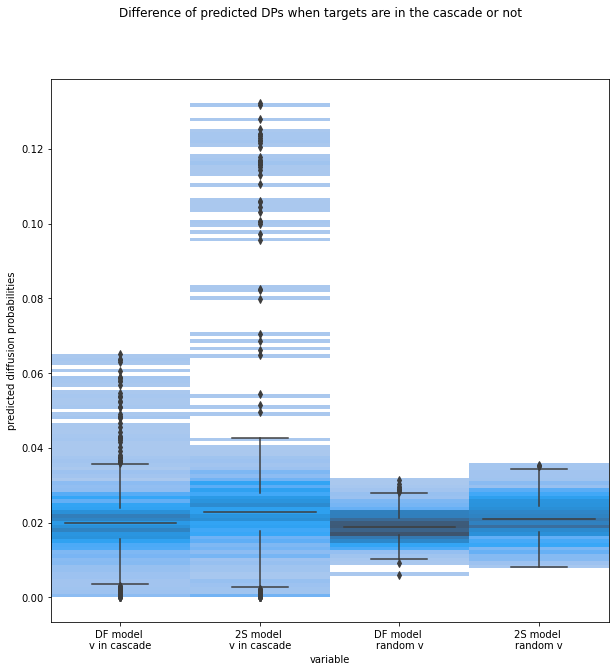

In [96]:
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x="variable", y="value", data=pd.melt(df_mean), ax = ax)
sns.histplot(x="variable", y="value", data=pd.melt(df_mean),ax = ax)
ax.set_ylabel('predicted diffusion probabilities')
fig.suptitle('Difference of predicted DPs when targets are in the cascade or not')

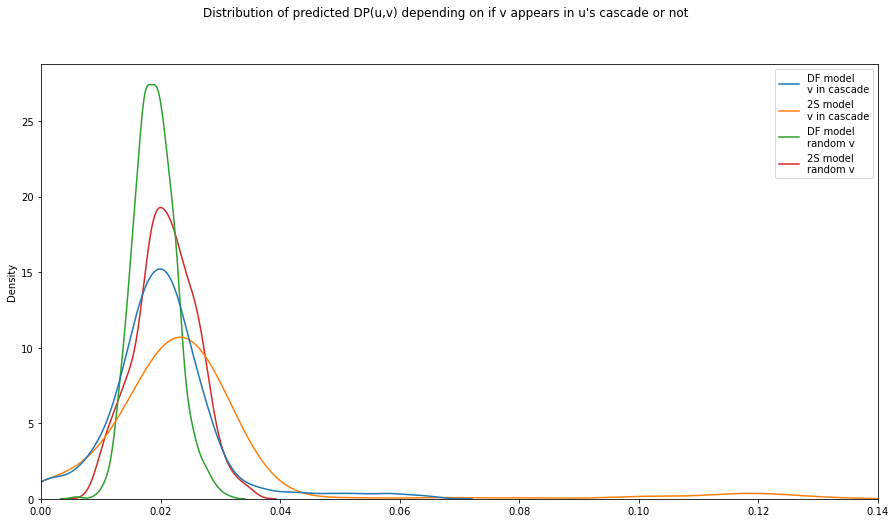

In [101]:
fig, ax = plt.subplots(figsize = (15,8))
sns.kdeplot(data=df_mean, ax = ax)
ax.set_xlim(0,0.14)
fig.suptitle("Distribution of predicted DP(u,v) depending on if v appears in u's cascade or not")
plt.show()

In [103]:
infos_cascades = pd.read_pickle(infos_cascades_path)
infos_cascades = infos_cascades[['User1', 'users2']].explode('users2').sample(n = 5000)

In [ ]:
d_pos = defaultdict(lambda : False)
for (u,v) in zip(df_labels.u, df_labels.v):
    d_pos[(u,v)] = True

In [ ]:
influencers = df_labels.groupby('u').count().index
targets = df_labels.groupby('v').count().index

random_pairs = random.sample([k for k in zip(influencers, targets) if not d_pos[k]], 1000)
positive_pairs = list(df_labels.sample(n=1000)[['u','v']].itertuples(index=False, name=None))


In [ ]:
results = []
for k in range(1000) :
    u,v = positive_pairs[k]
    dp_pos_df = model_df(feature_twitter(u,v)).item()
    dp_pos_2s = model_2s(feature_twitter(u,v)).item()
    w,t = random_pairs[k]
    dp_rand_df = model_df(feature_twitter(w,t)).item()
    dp_rand_2s = model_2s(feature_twitter(w,t)).item()

    results.append([dp_pos_df, dp_pos_2s, dp_rand_df, dp_rand_2s])


In [ ]:
df_results = pd.DataFrame(results)
df_results.columns = ['df model \nv in cascade', '2s model \nv in cascade', 'df model \nv not in cascade', '2s model \nv not in cascade']

### Simulation of independent cascades